In [1]:
import numpy as np # linear algebra
import struct
import os
from array import array
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Loading the data 
(Borrowed from kaggel - https://www.kaggle.com/code/hojjatk/read-mnist-dataset )
### The output array is stacked. This allows to have one dimension of array to  ( namely the first) to indicate the batch number when loading the data

In [2]:
class MNISTloader():
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            

        return images, labels
    
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (np.stack(x_train), np.stack(y_train)),(np.stack(x_test), np.stack(y_test))    
        

In [3]:
dataPath = '/Users/parassamsukha/Documents/Courses/fastAI/Data/MNIST/'
dataPath = '../Data/MNIST/'
training_labels_filepath = dataPath + 'train-labels.idx1-ubyte'
training_images_filepath = dataPath + 'train-images.idx3-ubyte'
test_labels_filepath = dataPath + 't10k-labels.idx1-ubyte'
test_images_filepath =  dataPath + 't10k-images.idx3-ubyte'
mnistData = MNISTloader(training_images_filepath,training_labels_filepath,test_images_filepath,test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnistData.load_data()

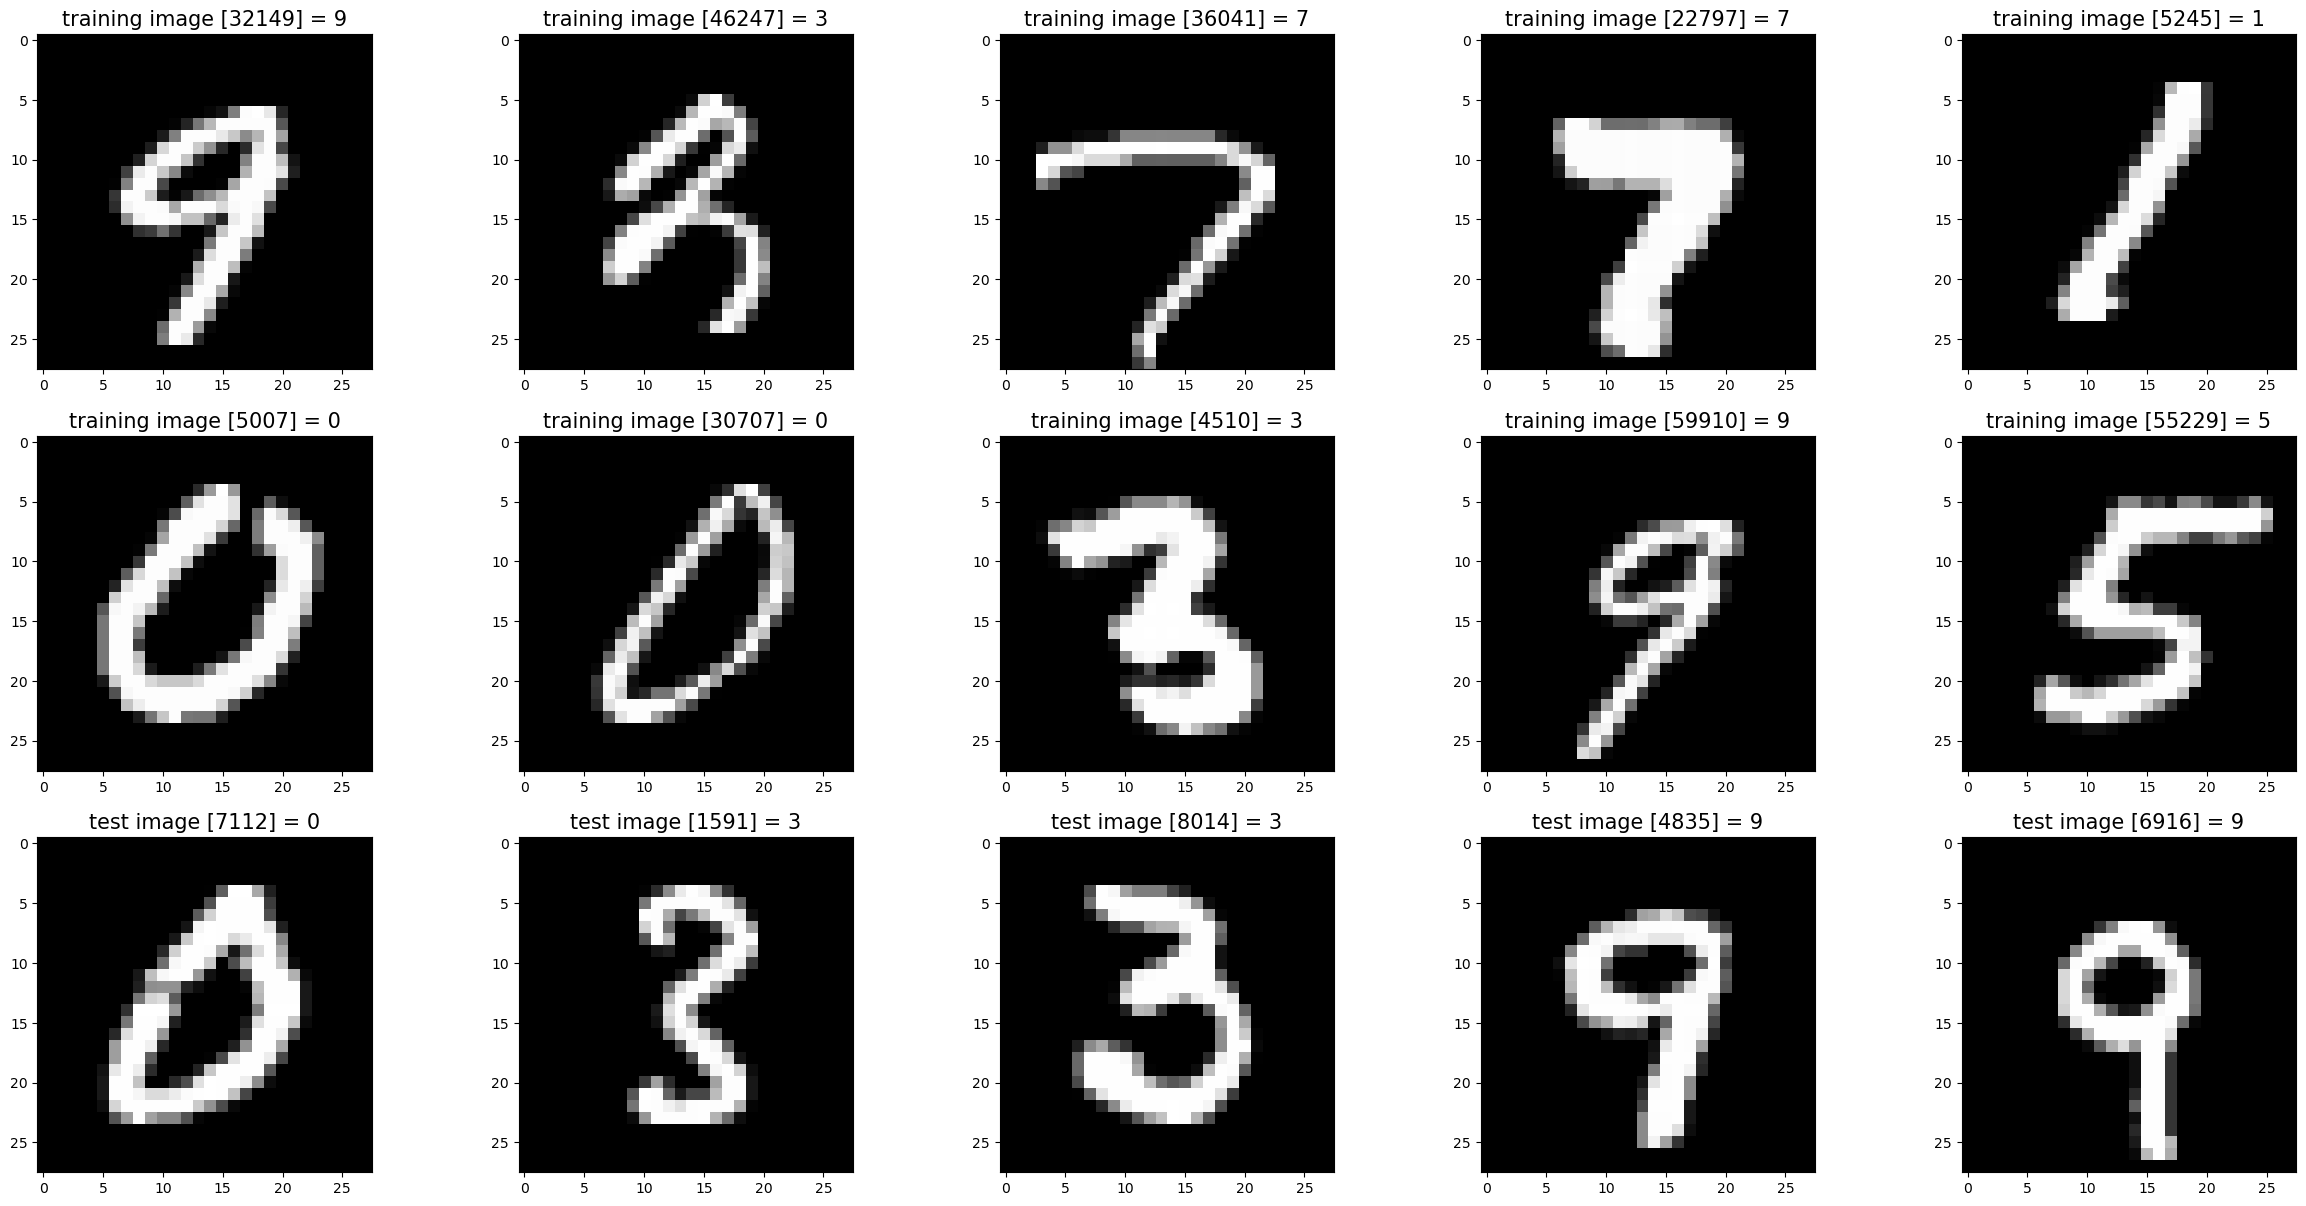

In [4]:
# Create list of files which will be sown at Random
import random
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r])) 
for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r])) 
    
    
#
# Helper function to show a list of images with their relating titles
#
import matplotlib.pyplot as plt
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
show_images(images_2_show,titles_2_show)

### Use the Dataloader class in pytorch to load the data. 
Covert array to tensor. It is then packaged by the dataset loader. And then use  dataloader - 
this helps with batching the data and shuffle automaticaly while training

In [6]:
# Load the data 
train_dataset1,test_dataset1  = mnistData.load_data()

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_dataset1[0], dtype=torch.float32), torch.tensor(train_dataset1[1], dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_dataset1[0], dtype=torch.float32), torch.tensor(test_dataset1[1], dtype=torch.long))



batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)


### Create fully connected neural network. 



First layer falttend 28*28 (784) pixels to a flattened image of 512 

Second layer is teh hidden layer 512 to 512

Last layer is the output layer with 10 output ( As there are 10 target values ) 

The first step in forward path is to flatten the array and then apply activation function for each layer. And no activation function for last layer. 

The Net class inherits pytorch nn.Module class. It has __call__ method which is invoked when Net class is called as a function. In this call the data is assigned to x. 

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # Input layer (flattened image) to hidden layer
        self.fc2 = nn.Linear(512, 512)   # Hidden layer to another hidden layer
        self.fc3 = nn.Linear(512, 10)    # Hidden layer to output layer (9 classes)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the 2D image to 1D
        x = F.relu(self.fc1(x))  # Apply ReLU activation
        x = F.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)          # No activation on the output (for cross-entropy loss)
        return x

model = Net()  # Move the model to the GPU if available

## Define the optimizer and loss function 
CrossEntropyLoss is used for multi-class classification

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer
criterion = nn.CrossEntropyLoss()  #


### Training 
A batch is a subset of data used to calculate loss ( in this case batch size is 64 samples) and update the gradient.

A run though the whole samples ( in this case 60,000 so total of 938 batches ) makes it one epoch. Hence one epoch is running though the whole training set. The order of the sample in batch in new epoch are not the same - hence letting the model train of different combinatin of sample. The Dataloader used above helps in making sure that this accounted for ( using Shuffling at the start of epoch ).

In [9]:
#Training 
num_epochs = 200
loss_history_epoch = []  #Used to store median loss of each epoch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {device}")

for epoch in range(num_epochs):
    loss_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU
#         print(batch_idx,epoch,len(target))
        optimizer.zero_grad()   # Zero the gradients
        output = model(data)    # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()         # Backpropagate
        optimizer.step()        # Update weights
        loss_history.append(loss.item())
#         if batch_idx % 1000 == 0:
#             print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
    print(f"Epoch: {epoch+1}/{num_epochs},Target: {target[0:4]}, loss: {np.mean(loss_history[-938:])}")
    loss_history_epoch.append(np.median(loss_history))
    loss_history = []
    

Using device: cpu
Epoch: 1/200,Target: tensor([0, 3, 9, 4]), loss: 0.4953404218911616
Epoch: 2/200,Target: tensor([9, 0, 5, 4]), loss: 0.11103581462992725
Epoch: 3/200,Target: tensor([5, 8, 2, 0]), loss: 0.08514581252632142
Epoch: 4/200,Target: tensor([1, 7, 8, 3]), loss: 0.0747335145566692
Epoch: 5/200,Target: tensor([2, 5, 8, 2]), loss: 0.06821778480426224
Epoch: 6/200,Target: tensor([6, 9, 9, 1]), loss: 0.06840261627834585
Epoch: 7/200,Target: tensor([8, 7, 3, 9]), loss: 0.07125074490194898
Epoch: 8/200,Target: tensor([1, 9, 3, 5]), loss: 0.060664808349078225
Epoch: 9/200,Target: tensor([1, 9, 9, 3]), loss: 0.0666350484229942
Epoch: 10/200,Target: tensor([2, 6, 2, 6]), loss: 0.06433175932400044
Epoch: 11/200,Target: tensor([3, 6, 4, 4]), loss: 0.06398227853342585
Epoch: 12/200,Target: tensor([6, 9, 6, 1]), loss: 0.06021601534171178
Epoch: 13/200,Target: tensor([8, 4, 5, 0]), loss: 0.05760130101578064
Epoch: 14/200,Target: tensor([4, 9, 1, 1]), loss: 0.05723293468863029
Epoch: 15/200

Epoch: 118/200,Target: tensor([2, 0, 0, 9]), loss: 0.03588022212255742
Epoch: 119/200,Target: tensor([4, 4, 1, 1]), loss: 0.01913891110800342
Epoch: 120/200,Target: tensor([2, 9, 0, 4]), loss: 0.020538027821108584
Epoch: 121/200,Target: tensor([7, 2, 0, 9]), loss: 0.032984839135105776
Epoch: 122/200,Target: tensor([2, 2, 3, 3]), loss: 0.03464982846662945
Epoch: 123/200,Target: tensor([5, 1, 5, 6]), loss: 0.036830204820981274
Epoch: 124/200,Target: tensor([4, 5, 6, 7]), loss: 0.015354066972450196
Epoch: 125/200,Target: tensor([7, 8, 1, 4]), loss: 0.012691336401928521
Epoch: 126/200,Target: tensor([7, 0, 4, 0]), loss: 0.03661708463021951
Epoch: 127/200,Target: tensor([3, 7, 9, 4]), loss: 0.07607501852125834
Epoch: 128/200,Target: tensor([8, 0, 6, 5]), loss: 0.030444528286910574
Epoch: 129/200,Target: tensor([9, 9, 5, 3]), loss: 0.03847943187115401
Epoch: 130/200,Target: tensor([0, 8, 8, 3]), loss: 0.02897829040601905
Epoch: 131/200,Target: tensor([4, 0, 3, 3]), loss: 0.019168821746166704

### Plots to see loss as a function of learning rate  and Batch Size

In [ ]:
script_dir = os.getcwd()
plotDir = os.path.join(script_dir , 'plots_MNIST')
plt.rcParams.update({'font.size': 18})
batch_size = train_loader.batch_size
lr = optimizer.param_groups[0]['lr']
print(f"Current learning rate: {lr}")

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(loss_history_epoch)
ax.set_xlabel("Epoch Number", fontsize=18)  # X-axis title and font size
ax.set_ylabel("Loss (Cross Entropy)", fontsize=18)  # Y-axis title and font size
ax.set_title(f"Batch Size = {batch_size}, LR = {lr}", fontsize=18)  # Title with parameters


filename = f"loss_plot_BaSz_{batch_size}_lr_{lr}.png"
fig.savefig(os.path.join(plotDir,filename),bbox_inches="tight")


### Observation:  For batch size of 64 and lr = 0.001 small change in cross entropy loss observed. This maybe due to small batch size.

### Effect of Batch Size (BaSz), Learning rate =  0.001



#### BaSz = 64 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_64_lr_0.001.png)

#### BaSz = 128 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_128_lr_0.001.png)

#### BaSz = 256 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_256_lr_0.001.png)

#### BaSz = 512 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_512_lr_0.001.png)

### Observation:  For batch size of 64 and lr = 0.001 small change in cross entropy loss observed. This maybe due to small batch size.

### Effect of Batch Size (BaSz), Learning rate =  0.001



#### BaSz = 64 ![A](plots_MNIST/loss_plot_BaSz_64_lr_0.001.png)

#### BaSz = 128 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_128_lr_0.001.png)

#### BaSz = 256 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_256_lr_0.001.png)

#### BaSz = 512 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_512_lr_0.001.png)

### Effect of learning rate (LR) , Batch Size = 256

#### LR = 0.01 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_256_lr_0.01.png)

#### LR = 0.001 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_256_lr_0.001.png)

#### LR = 0.0001 ![Loss Plot LR 0.001](plots_MNIST/loss_plot_BaSz_256_lr_0.0001.png)

## Evaluate the performanc of model on test set 
Since the gradient are not required during inference they are turned off to save memory

In [ ]:
#Evaluate
def test():
    correct = 0
    total = 0
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)  # Get predicted class
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print(f"Accuracy on test set: {100 * correct / total:.2f}%")

test()